- [샘플링방법](https://academic.naver.com/article.naver?doc_id=638266812)  
- [언더샘플링 방법 설명](https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/)

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings  ##warning sign 출력 무시
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x)  ##scientific notation 삭제
plt.rcParams['font.family'] = 'Malgun Gothic'  ##한글폰트 설정
plt.rcParams['axes.unicode_minus'] = False    ##마이너스기호 깨짐 방지

In [44]:
## 사용할 데이터 불러오기 (펭귄 데이터)
df = sns.load_dataset("penguins")
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.10000,18.70000,181.00000,3750.00000,Male
1,Adelie,Torgersen,39.50000,17.40000,186.00000,3800.00000,Female
2,Adelie,Torgersen,40.30000,18.00000,195.00000,3250.00000,Female
3,Adelie,Torgersen,nan,nan,nan,nan,NaN
4,Adelie,Torgersen,36.70000,19.30000,193.00000,3450.00000,Female


# 중복값, 결측값 처리

## 중복값 파악하기
- df.duplicated(subset = none, keep = 'first/'last'/False) 
    - subset: 중복값을 확인할 column의 list. 지정하지 않을 시 전체 column을 포함해 중복값을 확인함
    - keep: 몇번째 데이터를 제외하고 중복여부를 True로 리턴할지 결정. 'first'는 첫번째 중복값을 제외한 row에 True를 리턴한다. False는 모든 row에 True값 리턴
- df.duplicated에서 True값이 나오면 중복된 데이터라는 점을 이용해 중복데이터를 삭제할 수도 있음

In [3]:
df[df.duplicated(subset = ['species', 'island'], keep ='first')]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
1,Adelie,Torgersen,39.50000,17.40000,186.00000,3800.00000,Female
2,Adelie,Torgersen,40.30000,18.00000,195.00000,3250.00000,Female
3,Adelie,Torgersen,nan,nan,nan,nan,NaN
4,Adelie,Torgersen,36.70000,19.30000,193.00000,3450.00000,Female
5,Adelie,Torgersen,39.30000,20.60000,190.00000,3650.00000,Male
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,nan,nan,nan,nan,NaN
340,Gentoo,Biscoe,46.80000,14.30000,215.00000,4850.00000,Female
341,Gentoo,Biscoe,50.40000,15.70000,222.00000,5750.00000,Male
342,Gentoo,Biscoe,45.20000,14.80000,212.00000,5200.00000,Female


In [11]:
ex2 = df[df.duplicated(subset = ['species', 'island'], keep = False)]  ## 중복된 데이터만 저장
ex3 = df[~ df.duplicated(subset = ['species', 'island'], keep = 'first')]  ## 중복된 데이터 없이 저장

## 결측값 처리

### 결측값 파악하기

In [12]:
## column별 결측값 개수를 세기
print(df.isnull().sum())

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64


<AxesSubplot:>

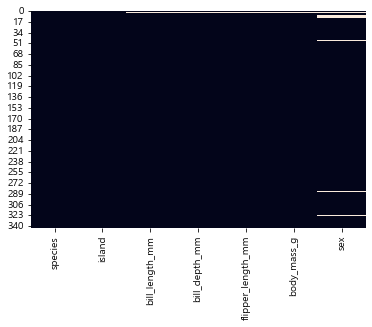

In [13]:
## 결측값이 나타나는 패턴을 시각화하기
sns.heatmap(df.isnull(), cbar = False)

### 1. 결측값 채우기(보간법)
- df[column명].fillna(값) : 모든 결측치를 지정한 값으로 대체
- df[column명].fillna(method = 'pad') : 결측치의 바로 직전 값으로 대체함
- df[column명].fillna(method = 'bfill') : 결측치의 바로 다음 값으로 대체함

In [45]:
## bill_length_mm 컬럼을 평균값으로 대체 (단일값 대체)
df['bill_length_mm'].fillna( df['bill_length_mm'].mean() , inplace = True)

In [12]:
print(df.isnull().sum())

species               0
island                0
bill_length_mm        0
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64


### 2. 결측값 제거
- df.dropna 이용

In [46]:
## 결측값을 제거하는 경우
df.dropna(subset = ['bill_depth_mm', 'flipper_length_mm', 'body_mass_g','sex'], inplace = True)
print(df.isnull().sum())

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


# 이상치 처리
- 데이터의 크기가 평균적인 분포에서 너무 멀어질 경우 모델 학습에 왜곡이 생길 수 있음. 따라서 머신러닝 학습을 수행할 때 이상치를 없애거나 다른 값으로 처리하는 작업이 필요함

### 1. 표준정규분포를 이용한 이상치 처리
- 데이터를 정규분포라고 가정하고, 평균으로부터 $\pm * n * \sigma$ 를 벗어나면 아웃라이어로 판단하는 방법
- $3\sigma$가 전체의 99%를 차지하기 때문에 보통 n의 값을 3으로 설정하여 사용함

In [27]:
z_values = zscore(df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]) ## 컬럼별 z-score 계산
abs_z_values = np.abs(z_values)

index_filtered = (abs_z_values < 3).all(axis = 1)  ## z-score의 절대값이 3이하인 데이터의 index만 추출
df_filtered = df[index_filtered]                   ## 추출한 index의 데이터프레임만 출력함
df_filtered.tail(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
338,Gentoo,Biscoe,47.20000,13.70000,214.00000,4925.00000,Female
340,Gentoo,Biscoe,46.80000,14.30000,215.00000,4850.00000,Female
341,Gentoo,Biscoe,50.40000,15.70000,222.00000,5750.00000,Male
342,Gentoo,Biscoe,45.20000,14.80000,212.00000,5200.00000,Female
343,Gentoo,Biscoe,49.90000,16.10000,213.00000,5400.00000,Male


### 2. IQR을 이용한 이상치 처리
- IQR(Interquartile Range)은 제1사분위와 3사분위 사이의 범위를 말함
- 통상적으로 (Q1/Q3 $\pm$ IQR * 1.5) 의 구간을 벗어난 값들을 이상치로 간주함

In [33]:
q1 = df['bill_length_mm'].quantile(.25)
q3 = df['bill_length_mm'].quantile(.75)
iqr = q3 - q1
df_filtered = df.query('(@q1 - 1.5 * @iqr) <= bill_length_mm <= (@q3 + 1.5 * @iqr)')    ##Q1-1.5IQR보다 크고 Q3+1.5IQR보다 작은 수
df_filtered

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.10000,18.70000,181.00000,3750.00000,Male
1,Adelie,Torgersen,39.50000,17.40000,186.00000,3800.00000,Female
2,Adelie,Torgersen,40.30000,18.00000,195.00000,3250.00000,Female
4,Adelie,Torgersen,36.70000,19.30000,193.00000,3450.00000,Female
5,Adelie,Torgersen,39.30000,20.60000,190.00000,3650.00000,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.20000,13.70000,214.00000,4925.00000,Female
340,Gentoo,Biscoe,46.80000,14.30000,215.00000,4850.00000,Female
341,Gentoo,Biscoe,50.40000,15.70000,222.00000,5750.00000,Male
342,Gentoo,Biscoe,45.20000,14.80000,212.00000,5200.00000,Female


# 데이터 인코딩
## Label Encoding
- 카테고리 변수를 코드형 숫자 값으로 변환하는 것  
    ['TV', '냉장고', '세탁기'] -> [0,1,2]
- LabelEncoder class를 객체로 생성한 후 fit()과 transform()을 호출해서 수행
- 선형회귀에서는 사용하기 어려움 b.c) 범주형자료가 숫자로 변하면서 크고 작음의 가중치가 부여되어 예측 성능이 떨어지는 경우가 발생함 (이것을 극복하기 위해 One-Hot Encoding을 사용)

In [46]:
from sklearn.preprocessing import LabelEncoder

## 아래 코드와 같이 범주형 데이터를 한번에 transform할 수 있지만, 역코딩에서 문제가 생길 수 있음
df2 = df.copy(deep = True)
le = LabelEncoder()
df2[['species', 'island', 'sex']] = df2[['species', 'island', 'sex']].apply(le.fit_transform)
df2.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.10000,18.70000,181.00000,3750.00000,1
1,0,2,39.50000,17.40000,186.00000,3800.00000,0
2,0,2,40.30000,18.00000,195.00000,3250.00000,0
4,0,2,36.70000,19.30000,193.00000,3450.00000,0
5,0,2,39.30000,20.60000,190.00000,3650.00000,1


In [47]:
print(le.inverse_transform([0,1]))    ##le Encoder에 마지막으로 transform된 것이 성별 변수이기 때문에 이전 변수들은 역코딩 불가
print(le.inverse_transform([2]))

['Female' 'Male']


ValueError: y contains previously unseen labels: [2]

만약 역코딩을 고려한다면 아래 예시와 같이 column마다 새로운 LabelEncoder를 만들어서 저장해주는 것이 좋다.

In [52]:
le_species = LabelEncoder()
le_island = LabelEncoder()
le_sex = LabelEncoder()

df2 = df.copy(deep = True)
df2['species'] = le_species.fit_transform(df2['species'])
df2['island'] = le_island.fit_transform(df2['island'])
df2['sex'] = le_sex.fit_transform(df2['sex'])
df2.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.10000,18.70000,181.00000,3750.00000,1
1,0,2,39.50000,17.40000,186.00000,3800.00000,0
2,0,2,40.30000,18.00000,195.00000,3250.00000,0
4,0,2,36.70000,19.30000,193.00000,3450.00000,0
5,0,2,39.30000,20.60000,190.00000,3650.00000,1


In [57]:
print(le_island.classes_)                   ##어떤 값들이 인코딩되었는지 확인
print(le_island.inverse_transform([0,1,2])) ##원본 데이터로 디코딩

['Biscoe' 'Dream' 'Torgersen']
['Biscoe' 'Dream' 'Torgersen']


## One-Hot Encoding
- One-Hot: 여러개의 속성 중 단 한 개의 속성만 1로 표시한다
- n개의 범주를 가진 범주형변수에 (n-1)개 컬럼을 만들고, 1과 0으로 해당 row가 가진 값을 표시
- One-Hot Encoding 방법
    - sklearn OneHotEncoder 사용시: 사용 전 모든 문자열은 숫자형으로 변환해야 하고, 입력값으로 2차원 데이터가 필요
    - get_dummies: 숫자형으로 변환할 필요 없이 바로 사용가능

### 1. pandas에 내장된 get_dummies 이용시
- pd.get_dummies(data, prefix = None, prefix_sep = ' _ ', dummy_na = False, columns = None, sparse = False, drop_first = False, dtype = None)
    - data: 원핫인코딩할 데이터
    - prefix: 원핫인코딩으로 새로 생성된 column 뒤에 추가로 붙일 문자열
    - prefix_sep: prefix 문자열 앞에 붙일 구분자 문자열
    - dummy_na: True일시, NA값도 하나의 값으로 보고 원핫인코딩함
    - columns: 인코딩할 컬럼이름을 리스트로 입력. None일시 데이터의 모든 object타입 범주형 데이터를 인코딩함
    - sparse: True일시 원핫인코딩된 컬럼들은 SparseArray로 처리되고 False일시 numpy array로 처리됨
    - drop_first: True일시 n-1개의 컬럼을 만듦. False일시 하위변수 n개 전부에 column을 만듦
    - dtype: 인코딩된 컬럼의 데이터타입

In [59]:
pd.get_dummies(df, drop_first = True)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen,sex_Male
0,39.10000,18.70000,181.00000,3750.00000,0,0,0,1,1
1,39.50000,17.40000,186.00000,3800.00000,0,0,0,1,0
2,40.30000,18.00000,195.00000,3250.00000,0,0,0,1,0
4,36.70000,19.30000,193.00000,3450.00000,0,0,0,1,0
5,39.30000,20.60000,190.00000,3650.00000,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...
338,47.20000,13.70000,214.00000,4925.00000,0,1,0,0,0
340,46.80000,14.30000,215.00000,4850.00000,0,1,0,0,0
341,50.40000,15.70000,222.00000,5750.00000,0,1,0,0,1
342,45.20000,14.80000,212.00000,5200.00000,0,1,0,0,0


### 2. sklearn의 OneHotEncoder 사용시
- 변수 값의 유형에 따라 새로운 변수를 추가해 고유 값에 해당하는 컬럼에만 1을 표시하고 나머지 컬럼은 0을 표시
- 원-핫 : 여러 개의 속성 중 단 한개의 속성만 1로 표시
- OneHotEncoder class 사용 : 사용 전 모든 문자열은 숫자형으로 변환해야하고, 입력 값으로 2차원 데이터가 필요함

# Feature Scaling
- 선형회귀에서 독립변수(X) 변환 (스케일링/정규화)
     - 표준화나 정규화 수행<br>
     - 스케일링/정규화를 수행한 데이터셋에 다시 다항 특성을 적용하여 변환(보통 ㄱ으로 예측 성능에 향상이 없을 경우 이 방법 적용)
     - **로그 변환** : ㄱ,ㄴ보다 훨씬 많이 사용되는 변환 방법(ㄱ은 예측 성능 향상을 크게 기대하기 어려운 경우가 많고, ㄴ은 피처의 개수가 많을 경우 다항 변환으로 생성되는 피처의 개수가 기하급수로 늘어나서 과적합의 이슈가 발생할 수 있기 때문)
- 선형회귀에서 종속변수(y) 변환 (스케일링/정규화)
    - 로그변환
    - 정규화, 표준화
    - 다항변수
- sklearn에서 피처 정규화를 할 때 주의할 점
    - fit(): 데이터 변환을 위한 기준정보를 적용 (예를 최대/최솟값 등)
    - transform(): fit()에서 설정한 정보를 이용해 데이터를 변환함  
    - fit_trnasform(): fit()과 transform()을 한번에 적용  
     

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxSclaer, PolynomialFeatures

## 표준화(Standardization)
- 데이터를 정규분포에 근사시킴 (평균이 0, 분산이 1)
- 일부 머신러닝 모델(선형회귀, 로지스틱회귀, SVM 등)은 데이터가 정규분포를 따른다고 가정하기 때문에 학습 이전에 표준화를 적용하는 것이 중요함

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

scaler.fit(df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']])
scaled_df=pd.DataFrame(scaler.transform(df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]))
df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] = scaled_df    ## 원데이터 변경

## 정규화(Normalization)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']])
scaled_df=scaler.transform(df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']])
df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']] = scaled_df    ## 원데이터 변경

# 샘플링
- 레이블이 불균형한 분포를 가진 데이터셋을 학습시킬 때 예측 성능의 문제가 발생할 수 있음
- 정상 레이블의 데이터 건수에 비해 이상 레이블의 데이터 건수가 현저히 적기 때문에 발생함<br>
  (정상적인 신용카드 사용 0, 신용카드 사기 사용 1일 경우 0이 월등히 많음)
- 이상 레이블을 가지는 데이터 건수가 매우 적기 때문에 제대로 다양한 유형을 학습하지 못하는 반면<br>
  정상 레이블을 가지는 데이터 건수가 매우 많기 때문에 일방적으로 정상 레이블에 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워짐  
- 오버샘플링과 언더샘플링이 대표적인 방법이며, 오버샘플링이 예측 성능상 더 유리한 경우가 많아 주로 사용됨
- train set에만 쓰는 것이고 test set에는 사용하지 않음

## 오버샘플링(Oversampling)
- 적은 데이터셋을 증식하여 학습을 위한 충분한 데이터를 확보하는 방법
- 동일한 데이터를 단순히 증식하는 방법은 과적합(Overfitting)이 되기 때문에 의미가 없으므로, 원본 데이터의 피처값들을 아주 약간만 변경하여 증식시키는 것이 유리함


- 대표적인 방법으로 **SMOTE(Synthetic Minority Over-sampling Technique)**가 있음
- SMOTE : 적은 데이터셋에 있는 개별 데이터들의 KNN(K최근접이웃, K Nearest Neighbor)을 찾아서<br>
  이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,2:5], df.iloc[:,-1] , test_size = 0.3, random_state = 999)

In [48]:
y_train = pd.DataFrame(y_train, columns = ['sex'])

<AxesSubplot:xlabel='sex', ylabel='count'>

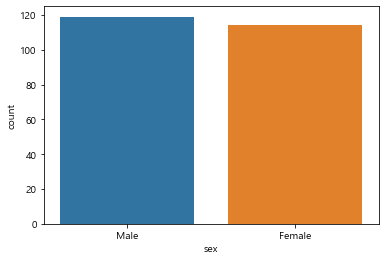

In [49]:
sns.countplot(data= y_train, x = 'sex')

### 1. 랜덤오버샘플링
- minor class의 instance를 임의로 복제하여 수를 늘린다  
[장점]
- 언더샘플링에 비해 데이터 손실이 없다
- 언더샘플링에 비해 일반적으로 성능이 뛰어나다고 알려져있다  
[단점]
- minor class를 학습할 때 과적합 우려가 있다 (같은 데이터를 여러번 학습하기 때문에)

In [50]:
import imblearn.over_sampling as osam    

ros = osam.RandomOverSampler()
oversampled_X, over_sampled_Y = ros.fit_resample(X_train, y_train)  ##y_train이 숫자 0,1로 나뉘어있으면 오류가 난다
print(over_sampled_Y.value_counts())

sex   
Male      119
Female    119
dtype: int64


### 2. Synthetic Minority Over-sampling Technique (SMOTE)
- minor class의 instance를 단순하게 복제할 때 생기는 과적합 이슈를 피하기 위해, minor class의 data에서 개별 데이터들의 KNN(K최근접이웃)을 찾아서 이 데이터와 K개 이웃의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터를 생성한다  
[장점]
- 랜덤오버샘플링보다 과적합 가능성이 줄어든다
- 정보손실 우려가 없다  
[단점]
- 고차원 데이터에 효율적이지 않다
- minor class끼리 최근접이웃을 찾기 때문에, 이 과정에서 major class의 위치가 고려되지 않고, 클래스가 겹치거나 노이즈가 만들어진다

**(참고)** 
- imblearn이 제대로 설치되지 않을 때는 (폴더 접근 오류)  
!pip install --user imblearn 으로 설치하면 된다
- 스터디 예제코드는 오버샘플링을 수행하는 코드가 fit_sample로 되어있는데, 내 jupyter환경에서는 fit_resample로 돌려야 결과가 나온다. 

In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print(len(X_train), len(y_train))

233 233


### 3. Borderline-SMOTE
- minority class와 majority class의 경계에 있는 minor class 샘플을 늘려 분류하기 어려운 부분을 집중적으로 학습할 수 있도록 함

In [64]:
from imblearn.over_sampling import BorderlineSMOTE   

B_SMOTEos = BorderlineSMOTE()
oversampled_X, oversampled_Y = B_SMOTEos.fit_resample(X_train, y_train)
print(len(X_train), len(y_train))

233 233


### 4. Modified synthetic minority oversampling technique (MSMOTE)
- SMOTE의 성능을 향상시킨 것으로 minor class의 근본적인 분포와 잠재적인 노이즈를 고려하여 minor class를 생성한다
- minor class의 instance를 security/safe samples, border samples, latent noise samples로 나누는데, 이 때 나누는 기준은 minor class intance와 training data 간의 거리이다. 
- Noise samples는 상대적으로 분류기의 성능을 낮추고, security/safe는 성능을 높일 수 있고, border samples는 앞의 두 그룹 중 한 곳에 속하기 애매한 데이터들이다
- MSMOTE는 데이터를 만들 때 security samples 위주로 생성하고, latent noise sample에 대해서는 아무것도 하지 않는다

In [59]:
import smote_variants

msmote = smote_variants.MSMOTE()
X_msmote, y_msmote = msmote.sample(X_train, y_train)

2022-03-23 16:30:56,373:INFO:MSMOTE: Running sampling via ('MSMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### 5. Adaptive Synthetic Sampling (ADASYN)
- 개별 minor class에 가까운 KNN 데이터 중, 무작위로 선택된 데이터 사이의 직선상에 가상의 소수 클래스 데이터를 만들어냄

In [56]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy = "not majority", n_neighbors = 5, random_state = 0)   ##오류가 왜 뜨는지.... 
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

ValueError: No samples will be generated with the provided ratio settings.

## 언더샘플링(Undersampling)
- 많은 데이터셋을 적은 데이터셋 수준으로 감소시킴
- 오버샘플링에 비해 minor class의 과적합 이슈를 방지할 수 있지만, 정상 레이블의 데이터를 감소시켜 오히려 정상 레이블의 제대로 된 학습이 불가능할 수 있음

### 1. 랜덤 언더샘플링

In [88]:
import imblearn.under_sampling as usam
rus = usam.RandomUnderSampler()
undersampled_X, undersampled_Y = rus.fit_resample(X_train, y_train)
print(undersampled_Y.value_counts())

sex   
Male      114
Female    114
dtype: int64


### 2. Condensed Nearest Neighbor (CNN)
- major class에서 밀집된 데이터가 없을 때까지 데이터를 제거하여 major 데이터의 분포에서 대표적인 데이터만 남게 하는 방법

In [90]:
krus = usam.CondensedNearestNeighbour(n_neighbors = 3)
undersampled_X, undersampled_Y = krus.fit_resample(X_train, y_train)
print(undersampled_Y.value_counts())

sex   
Female    114
Male       48
dtype: int64


### 3. Edited Nearest Neighbors (ENN)
- minor data 주의에 인접해 있는 major data를 제거하여 데이터의 밸런스를 맞추는 방법

In [93]:
erus = usam.CondensedNearestNeighbour(n_neighbors = 3, n_jobs = 1)
undersampled_X, undersampled_Y = erus.fit_resample(X_train, y_train)
print(undersampled_Y.value_counts())

sex   
Female    114
Male       48
dtype: int64


### 4. NearMiss(NM) 언더샘플링
- Type1: 가장 가까운 3개의 minor class와 평균거리가 가장 가까운 하나의 majority class를 선택
- Type2: 가장 멀리있는 3개의 minor class와 평균거리가 가장 가까운 하나의 majority class를 선택
- Type3: majority class의 개수를 정하고 각 minority class에서 가장 가까운 것을 선택한다. (이 경우 majority class와 minority class가 경계선에 서로 겹치게 됨)

In [95]:
nrus1 = usam.NearMiss(n_neighbors = 3, version = 1)   ##타입을 변경하고 싶을 때 version을 1,2,3으로 바꿀 수 있음
undersampled_X, undersampled_Y = nrus1.fit_resample(X_train, y_train)
print(undersampled_Y.value_counts())

sex   
Male      114
Female    114
dtype: int64


### 5. Tomek's link method
- 클래스가 다른 두 데이터가 아주 가까이 붙어있다면 토멕링크가 된다. 토멕 링크를 찾은 다음 그 중에서 다수 클래스에 속하는 데이터를 제외하는 방법으로 경계선을 다수 클래스 쪽으로 밀어붙이는 효과가 있음

In [97]:
from imblearn.under_sampling import TomekLinks

X_samp, y_samp = TomekLinks().fit_resample(X_train, y_train)
print(y_samp.value_counts())

sex   
Female    114
Male      103
dtype: int64


### 6. One Sided Selection
- Tomek Link 방법과 Condensed Nearest Neighbor 기법의 장점만 섞은 것
- major class에서 토멕링크에 해당하는 데이터를 제거하고, 나머지 major data에 대해 Condensed Nearest Neighbor을 이용해 밀집된 데이터를 제거한다. 

In [99]:
from imblearn.under_sampling import OneSidedSelection

X_samp, y_samp = OneSidedSelection().fit_resample(X_train, y_train)
print(y_samp.value_counts())

sex   
Female    114
Male      100
dtype: int64
